<center>
    <h2><i>Edoardo Conti [278717]</i></h2>
</center>

# Particles in a box, version 2

Il progetto in questione consiste in una simulazione 2D di collissioni *elastiche* di $N=N_A+N_B$ particelle, rappresentate sotto forma di un _disco circolare_ di raggio $R = 0.04$ , limitate da un box *quadrato* di dimensioni $4\times 4$ .
<br>Le particelle sono divise in **due** specie differenziate da masse $M_A$ e $M_B$.

Le particelle sono soggette alla forza gravitazionale $g = 9.81$ diretta verso la direzione verticale (negativa) $Y$.

## Collisioni con i lati del box

Le collisioni con i quatro lati del box sono *elastiche*, quindi in presenza della conservazione d'energia.
Ovvero la componente della velocità **parallela** al lato del box è conservata, di contro, quella **perpendicolare** viene invertita, negando il valore.

## Collisioni tra 2 particelle

Anche le collisioni tra le particelle sono *elastiche*.
Nel momento in cui $2$ particelle di velocità $\vec{v}_1$ e $\vec{v}_2$ collidono si avranno le seguenti condizioni:
- $\vec{r}_{rel} = \vec{r}_1 - \vec{r}_2$ (posizione relativa dei due centri delle particelle)

- $\vec{v}_{rel} = \vec{v}_1 - \vec{v}_2$ (velocità relativa iniziale)

Dando luogo ai due nuovi valori di velocità, rispettivamente per la particella $1$ e $2$.

\begin{eqnarray}
\vec{v}^\prime_1 &=& \vec{v}_1 - \frac{2 M_2}{M_1 + M_2}\frac{\left(\vec{v}_{rel}\cdot\vec{r}_{rel}\right)}{\left(\vec{r}_{rel}\cdot\vec{r}_{rel}\right)}\vec{r}_{rel}\nonumber\\
\vec{v}^\prime_2 &=& \vec{v}_2 + \frac{2 M_1}{M_1 + M_2}\frac{\left(\vec{v}_{rel}\cdot\vec{r}_{rel}\right)}{\left(\vec{r}_{rel}\cdot\vec{r}_{rel}\right)}\vec{r}_{rel}
\end{eqnarray}

## Considerazioni energetiche

Nella realtà l'energia si conserva, quindi definendo:

\begin{equation}
U_i = M_i g y_i
\end{equation}

come *energia potenziale* della particella $i$, dove $y_i$ è la distanza della particella dal lato inferiore del box, e

\begin{equation}
K_i = \frac{1}{2} M_i v_i^2 = \frac{1}{2} M_i \left(\vec{v}_i\cdot\vec{v}_i\right)
\end{equation}

*energia cinetica*, la somma di queste quantità, detta *energia meccanica*, è *costante* nel tempo.

Purtroppo però, per via di errori numerici introdotti tramite la simulazione numerica, **la legge della conservazione verrà violata** come si potrà vedere nei grafici a seguire.

## Classe Python 

In calce il codice Python della classe **BoxedParticles**, responsabile dell'andamento della simulazione. Questa è in grado di accettare, tramite la variazione di parametri nel momento dell'instanziamento, le condizioni iniziali del modello fisico, tra le quali:
- $init_s$ -> stato iniziale delle particelle, coordinate e velocità iniziali
- $N_A$ -> numero particelle specie $A$
- $N_B$ -> numero particelle specie $B$
- $M_A$ -> massa particelle specie $A$
- $M_B$ -> massa particelle specie $B$
- $T_{therm}$ -> tempo di termalizzazione

All'interno viene gestito l'intero apparato dedicato alla storicizzazione di dati per il calcolo delle energie *Cinetiche*, *Potenziali* e *Meccaniche*. Inoltre è descritto il processo step-by-step che descrive l'andamento delle particelle ad ogni passo $\Delta t$. **Il codice è stato commentato nel miglior modo, per non lasciare spazi ad equivoci.**

Durante il tempo di misurazione vengono catalogate:
- *coordinate* e *componenti delle velocità* di ogni singola particella divise per specie -> ($storeA$ e $storeB$)
- *energie cinetiche medie* della specie $A$ e $B$:
    \begin{equation}
    \langle K_A\rangle =\frac{1}{2 N_A} M_A\sum_{i=1}^{N_A} (\vec{v}_i\cdot\vec{v}_i)
    \end{equation}
    
    \begin{equation}
    \langle K_B\rangle =\frac{1}{2 N_B} M_B\sum_{i=1}^{N_B} (\vec{v}_i\cdot\vec{v}_i)
    \end{equation}
- *energie potenziali medie* della specie $A$ e $B$:
    \begin{equation}
    \langle U_A\rangle = \frac{1}{N_A} M_A g \sum_{i=1}^{N_A} y_i
    \end{equation}

    \begin{equation}
    \langle U_B\rangle = \frac{1}{N_B} M_B g \sum_{i=1}^{N_B} y_i
    \end{equation}

In [1]:
# Render
%matplotlib inline

# Librerie 
import numpy as np
import scipy.spatial.distance as distance
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Classe BoxedParticles, utilizzata per la simulazione di collisioni elastiche di un numero
# arbitrario di particelle di 2 specie diverse confinate in un box di dimensioni 4X4
class BoxedParticles:
    def __init__(self,
                 init_s = None,
                 n_a = None,
                 n_b = None,
                 m_a = None,
                 m_b = None,
                 tt = None   
                 ):
        self.init_s = np.asarray(init_s) # stato inziale delle particelle
        self.Na = n_a # n. particelle specie A
        self.Nb = n_b # n. particelle specie B
        self.Ma = m_a # massa particelle specie A
        self.Mb = m_b # massa particelle specie B
        self.ttherm = tt # Ttherm, thermalization interval
        self.N = self.Na + self.Nb # n. totale particelle 
        self.M = self.Ma * np.ones(self.N) # array masse particelle
        self.M[self.Na:] = self.Mb # 2nd metà array con massa seconda specie
        self.bounds = [0, 4, 0, 4] # limiti box [xmin, xmax, ymin, ymax]
        self.radius = 0.04 # raggio particella
        self.G = 9.81 # accelerazione gravitazionale
        self.state = self.init_s.copy() # stato instantaneo delle particelle (x,y,vx,vy)
        self.time_elapsed = 0 # tempo trascorso in secondi 
        self.i = 0 # contatore n. campionamenti
        self.j = 0 # contatore passi in t_therm
        self.storeA = np.ones((self.init_s.shape)) # array per storicizzazione particelle specie A
        self.storeB = np.ones((self.storeA.shape)) # array per storicizzazione particelle specie B
        self.Ka = np.array([]) # array per storicizzazione energie cinetiche nel t. specie A
        self.Kb = np.array([]) # array per storicizzazione energie cinetiche nel t. specie B
        self.Ua = np.array([]) # array per storicizzazione energie potenziali nel t. specie A
        self.Ub = np.array([]) # array per storicizzazione energie potenziali nel t. specie B
        
    # @chunks(l,n) -> l = array ; n = chunk  
    # @desc funzione utile per dividere in gruppi (chunks) un array
    def chunks(self, l = None, n = None):
        for i in range(0, len(l), n):
            yield l[i:i+n]

    # step2time(data, chunk) -> data = array ; chunk = n. discretizzazione  
    # @desc funzione utile per discretizzare array in funzione del tempo 
    #       partendo dall'array di dati in funzione dei step dt
    def step2time(self, data = None, chunk = None):
        # nuova risorsa output
        newData = np.array([])
        # divisione in chunks richiesti dell'array
        counter = len(list(self.chunks(data, chunk)))
        for i in range(counter):
            # elaborazione della media dei n. chunk elementi richiesti
            avg = (np.sum(list(self.chunks(data,chunk))[i]) / chunk)
            # popolazione nuova risorsa
            newData = np.append((newData), avg)
    
        return newData
    
    # sbs(dt) -> dt = passo incremento
    # @desc funzione che governa l'andamento della simulazione, aggiornando le coordinate
    #       delle particelle, identificando collisioni e alterazioni dovute, e raccolta
    #       informazioni da processare per calcolare Energie e distribuzioni
    def sbs(self, dt):
        # incremento tempo trascorso dt
        self.time_elapsed += dt
        
        # separazione coordinate e velocità particelle
        _coordsxy = self.state[:, :2]
        _vxy = self.state[:, 2:]
        
        # (x,y) = t * (vx,vy) -> aggiornamento posizione particelle
        _coordsxy += dt * _vxy

        # individuare particelle che collidono, calcolo distanza coordinate tra ogni coppia        
        _dist = distance.cdist(_coordsxy, _coordsxy, 'euclidean')
        # individuo le coppie di particelle che collidono. 2 particelle entrano in collisione 
        # quando la distanza misurata tra i loro centri è minore del diametro di una particella
        # numpy.where ritorna due array con gli indici che soddisfano la condizione sopra citata
        ids = np.where(_dist < (2 * self.radius))
        ids_1, ids_2 = ids
        found = (ids_1 < ids_2)
        ids_1 = ids_1[found]
        ids_2 = ids_2[found]
        
        # aggiornamento delle velocità delle particelle che collidono
        for i, j in zip(ids_1, ids_2):
            # (x,y) delle particelle i e j
            p1 = self.state[i, :2]
            p2 = self.state[j, :2]
            # (vx,vy) delle particelle i e j
            v1 = self.state[i, 2:]
            v2 = self.state[j, 2:]
            # massa delle particelle
            m1 = self.M[i]
            m2 = self.M[j]

            # posizione relativa 
            p_rel = p1 - p2
            # velocità relativa
            v_rel = v1 - v2

            # prodotto vettoriale tra posizione e velocità relative
            pp = np.dot(p_rel, p_rel)
            vp = np.dot(v_rel, p_rel)
            
            # calcolo nuove velocità secondo la formula data nella specifica
            v1_1 = v1 - (((2 * m2) / (m1 + m2)) * ((vp / pp) * p_rel))
            v2_1 = v2 + (((2 * m1) / (m1 + m2)) * ((vp / pp) * p_rel))
            
            # aggiornamento velocità dopo collisione
            self.state[i, 2:] = v1_1
            self.state[j, 2:] = v2_1
            
        # una particella collide con il bordo quando le coordinate 
        # del centro fuoriescono dal range definito da 'bounds'
        # si include la dimensione in quanto una particella tocca effettivamente il bordo
        # quando la sua coordinata più la propria dimensione coincide con il bordo stesso
        top_side_t = (self.state[:, 1] + self.radius > self.bounds[3])
        bottom_side_t = (self.state[:, 1] - self.radius < self.bounds[2])
        left_side_t = (self.state[:, 0] - self.radius < self.bounds[0])
        right_side_t = (self.state[:, 0] + self.radius > self.bounds[1])
        
        # aggiorno la posizione delle particelle interessate evitando di fuoriuscire dai bounds
        self.state[top_side_t, 1] = self.bounds[3] - self.radius
        self.state[bottom_side_t, 1] = self.bounds[2] + self.radius
        self.state[left_side_t, 0] = self.bounds[0] + self.radius
        self.state[right_side_t, 0] = self.bounds[1] - self.radius
        
        # aggiorno le velocità seguendo quanto descritto: la componente perpendicolare
        # diventa l'opposto dell'attuale, quella parallela rimane intatta        
        self.state[top_side_t, 3] = np.negative(self.state[top_side_t, 3])
        self.state[bottom_side_t, 3] = np.negative(self.state[bottom_side_t, 3])
        self.state[left_side_t, 2] = np.negative(self.state[left_side_t, 2])
        self.state[right_side_t, 2] = np.negative(self.state[right_side_t, 2])

        # campo gravitazione che incide su tutte le particelle
        self.state[:, 3] -= (self.M * self.G * dt)
        
        # misurazioni (simulazione standard -> Ttherm = 0)
        if(self.time_elapsed >= self.ttherm):
            # Tmeas iniziato
            # conteggio campionamenti = i
            self.i += 1
            
            # storicizzazione coordinate (x,y) e velocità (vx,vy) particelle divise per pop.
            popA = self.state[:self.Na,:]
            popB = self.state[self.Na:self.N,:]
            
            # concateno le misurazioni per collezzionare un array per ogni specie 
            self.storeA = np.concatenate([self.storeA, popA], axis=0)
            self.storeB = np.concatenate([self.storeB, popB], axis=0)
                
            # Misurazione Energia Cinetica ( K )             
            # risolvo sommatoria velocità, estraggo il magnitude della velocità
            # sfruttando il teora di pitagora
            vvA = 0.
            for iA in range(self.Na):
                vvA += (self.state[iA, 2] ** 2) + (self.state[iA, 3] ** 2)
            vvB = 0.
            for iB in range(self.Na,self.N):
                vvB += (self.state[iB, 2] ** 2) + (self.state[iB, 3] ** 2)
            
            # utilizzo formula data per calcolo energie cinetiche, che andranno 
            # storicizzate nell'array dedicato, divise per specie A e B
            kA = (1/2 * self.Na) * self.Ma * vvA
            kB = (1/2 * self.Nb) * self.Mb * vvB
            self.Ka = np.append(self.Ka, kA)
            self.Kb = np.append(self.Kb, kB)
            
            # Misurazione Energia Potenziale ( U )       
            yA_tot = 0.
            for iA in range(self.Na):
                yA_tot += (self.state[iA, 1])
            yB_tot = 0.
            for iB in range(self.Na,self.N):
                yB_tot += (self.state[iB, 1])
            
            # utilizzo formula data per calcolo energie potenziali, che andranno 
            # storicizzate nell'array dedicato, divise per specie A e B
            uA = (1 / self.Na) * self.Ma * self.G * yA_tot
            uB = (1 / self.Nb) * self.Mb * self.G * yB_tot
            self.Ua = np.append(self.Ua, uA)
            self.Ub = np.append(self.Ub, uB)
        else:
            # incremento contatore in t_therm
            self.j += 1
            # aggiungo misurazioni nulle alle strutture dati da memorizzare
            _zerod = np.zeros((30,4))
            self.storeA = np.concatenate([self.storeA, _zerod], axis=0)
            self.storeB = np.concatenate([self.storeB, _zerod], axis=0)
            # stesso comporamento per quanto riguarda le misurazioni delle energie
            self.Ka = np.append(self.Ka, 0.)
            self.Kb = np.append(self.Kb, 0.)
            self.Ua = np.append(self.Ua, 0.)
            self.Ub = np.append(self.Ub, 0.)
            
    # @getTmeas() -> no input
    # @desc funzione per ricavare il tempo di misurazione della simulazione
    def getTmeas(self):
        return self.time_elapsed - self.ttherm

## Inizializzazione
Di seguito il codice per la preparazione della simulazione. Le particelle vengono posizionate con coordinate randomiche all'interno del box senza, ovviamente, eccedere i limiti imposti. Queste saranno dotate di un vettore velocità uniformemente distribuito nell'intervallo $[-1.0, 1.0]$.

In [2]:
# Funzioni d'inizializzazione e preparazione per la simulazione

# @prepare(nA, nB, mA, mB, tt) -> nA=numero particelle specie A ; nB=(_) B
#                                 mA=massa particelle specie A ; mB=(_) B
#                                 tt=Ttherm
# @desc preparazione della simulazione con le condizioni iniziali date
def prepare(nA, nB, mA, mB, tt):
    n = nA + nB
    # esperimento ripetibile con condizioni iniziali dello stesso 'seme'
    np.random.seed(0)
    # 0 < (x,y) particelle < 4
    # -1 < (vx,vy) particelle < 1
    ranges = np.asarray([[0,4],[0,4],[-1,1],[-1,1]])
    # genera uno stato iniziale di un numero arbitrario particelle 
    # con componenti velocità uniormemente distribuite nell'invertvallo [-1,1]
    # e coordinate randomiche con range equivalente ai bounds
    init_s = np.random.uniform(ranges[:, 0], ranges[:, 1], size=(n, ranges.shape[0]))
    # tempo di campionamento ogni 0.1 secondi
    dt = 0.1 # 10 fps -> nel caso in cui la simulazione duri 100s
    return BoxedParticles(init_s, nA, nB, mA, mB, tt), dt

# @figprx() -> no input
# @desc # preparazione delle componenti grafiche
def figprx():
    fig = plt.figure(frameon=False)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax = fig.add_subplot(111, aspect='equal', autoscale_on=True, xlim=(0, 4), ylim=(0, 4))

    # definizione holder particelle, di seguito si definisce la forma, colore, segno e dimensione
    particles, = ax.plot([], [], color='orange', marker='o', linewidth=0, ms=6)
    particles2, = ax.plot([], [], color='c', marker='o', linewidth=0, ms=6)

    # rect -> box dove limitare la simulazione secondo i bound
    rect = plt.Rectangle(box.bounds[::2], 
                         box.bounds[1] - box.bounds[0], 
                         box.bounds[3] - box.bounds[2],
                         ec='none', lw=2, fc='none')
    ax.add_patch(rect)
    
    return fig, particles, particles2, rect, ax

# @init() -> no input
# @desc # funzione di richiamo iniziale utile per lo start dell'animazione
def init():
    # non fa altro che instanziare le figure e componenti sopra definite
    global box, rect
    particles.set_data([], [])
    particles2.set_data([], [])
    rect.set_edgecolor('none')
    
    return particles2, particles, rect

# @animate() -> no input
# @desc # step di simulazione per l'animazione
def animate(i):
    global box, rect, dt, ax, fig
    
    # richiamo funzione sbs (step-by-step) che governa l'andamento dell'animazione
    box.sbs(dt)
    
    # definizioen markersize, dimensione figura rappresentativa delle particelle
    ms = int(fig.dpi * 2 * box.radius * fig.get_figwidth() / np.diff(ax.get_xbound())[0])

    rect.set_edgecolor('k')
    # aggiunta particelle all'interno della simulazione
    particles.set_data(box.state[:box.Na, 0], box.state[:box.Na, 1])
    particles.set_markersize(ms)
    particles2.set_data(box.state[box.Na:box.N, 0], box.state[box.Na:box.N, 1])
    particles2.set_markersize(ms)
    
    return particles2, particles, rect

## Avvio Animazione
Ora è possibile scegliere le condizioni iniziali, ovvero si avranno $N_A = 30$ particelle con massa $M_A = 0.025$, e $N_B = 30$ particelle con massa $M_B = 0.05$. 
<br><br>Per animare la simulazione ho deciso di sfruttare il motore render in **HTML5**, questo comporta l'installazione del package *ffmpeg*.
Per i test effettuati, ho notato notevoli miglioramenti in termini di tempische rispetto ad altre simulazioni, quali i widget di Jupyter (*%matplotlib notebook*), JavaScript ...
<br><br>Essedo una prima animazione dimostrativa, *i valori iniziali relativi ai tempi sono stati scelti arbitrariamente*.

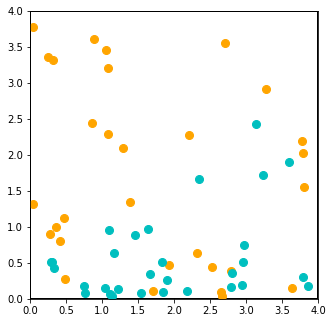

In [3]:
# lancio animazione sfruttando il render in HTML5 che sembra offrire una buona efficienza
# t -> secondi di animazione totali, che moltiplicati per i frame/s offrono i frames totali d'animazione
t = 80
# t_term -> tempo di termalizzazione in secondi
t_term = 10
# invocazione funzione di preparazione
box, dt = prepare(30, 30, 0.025, 0.05, t_term)
# init componenti grafiche
fig, particles, particles2, rect, ax = figprx()
# animazione
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=t*10, interval=20, blit=True)
HTML(anim.to_html5_video())
# se necessario è possibile salvare l'animazione in formato mp4 (rallenta esecuzione)
# anim.save('boxedparticled_1000_500.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

### Resoconto tempi simulazione
Il tempo totale della simulazione ( $\tau = \tau_{therm} + \tau_{meas}$ ):

In [4]:
box.time_elapsed

79.99999999999973

Tempo iniziale senza effettuare calcoli, dove il grafico risulterà piatto ( $\tau_{therm}$ ):

In [ ]:
box.ttherm

10

Tempo impiegato per le misurazioni ( $\tau_{meas}$ ):

In [ ]:
box.getTmeas()

69.99999999999973

## Grafici Energie 
Grazie ai dati raccolti ed elaborazioni effetuate su questi è possibile stilare dei grafici in funzione del tempo delle energie:
<br>$\langle K_A\rangle$<br>$\langle K_B\rangle$<br>$\langle U_A\rangle$<br>$\langle U_B\rangle$ .
<br>
<br>
Nel caso in cui sia impostato un $\tau_{therm}$ > 0 si noterà la <b>prima parte del grafico piatta</b>, questo è dovuto dalla mancata registrazione dei valori essendo nel periodo di termalizzazione. <br>*L'effetto è quindi voluto, mostrando l'inizio effettivo delle misurazioni.*

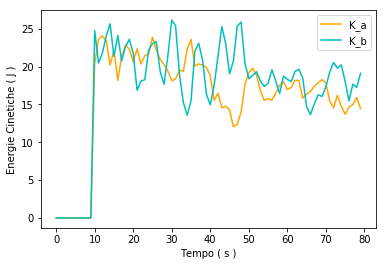

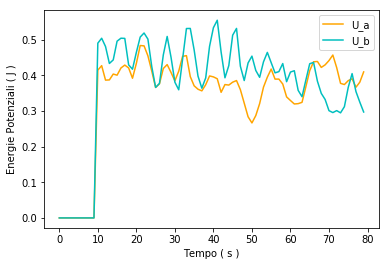

In [ ]:
# @plotFuncsE(status) -> status=0 per grafico energie cinetiche
#                        status=1 per grafici energie cinetiche e potenziali
# @desc # utilizzata per stampare grafici delle energie cinetiche e potenziali
def plotFuncsE(status):
    plt.plot(box.step2time(box.Ka, 10), color='orange', label='line 1')
    plt.plot(box.step2time(box.Kb, 10), color='c', label='line 1')
    plt.ylabel('Energie Cinetiche ( J )');
    plt.xlabel('Tempo ( s )');
    plt.legend(['K_a', 'K_b'], loc='upper right')
    plt.show()
    
    if(status):
        plt.plot(box.step2time(box.Ua, 10), color='orange')
        plt.plot(box.step2time(box.Ub, 10), color='c')
        plt.ylabel('Energie Potenziali ( J )');
        plt.xlabel('Tempo ( s )');
        plt.legend(['U_a', 'U_b'], loc='upper right')
        plt.show()

    # dati in funzione di dt, non del tempo
    # UbGraph = np.squeeze(box.Ub)
    # plt.plot(UbGraph)
    # plt.show()
    
plotFuncsE(1)

## Evoluzione Energie Totali
Ripeto la simulazione con $T_{meas}=100 s$, $T_{therm} = 0$ e $\Delta t = 0.1$, per poter analizzare il grafico dell'*energia totale* $E_{tot}$ (cinetica + potenziale) in funzione del tempo calcolata mediante la seguente formula data:

\begin{equation}
E_{tot} = N_A \left(\langle K_A\rangle +\langle U_A\rangle\right) + N_B \left(\langle K_B\rangle +\langle U_B\rangle\right)
\end{equation}

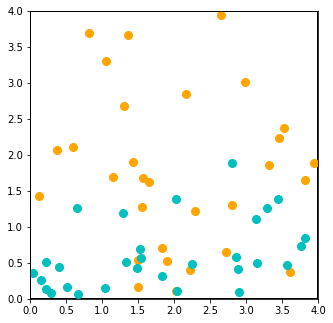

In [ ]:
# INPUT 
t = 100
t_term = 0
# invocazione funzione di preparazione
box, dt = prepare(30, 30, 0.025, 0.05, t_term)
# init componenti grafiche
fig, particles, particles2, rect, ax = figprx()
# animazione
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=t*10, interval=20, blit=True)
HTML(anim.to_html5_video())

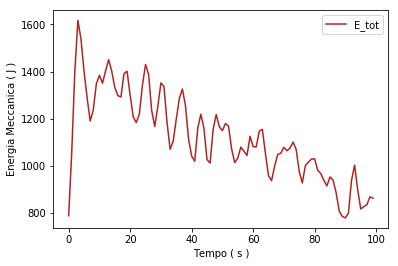

In [ ]:
# @plotFuncEtot() -> NO INPUT
# @desc # utilizzata per stampare grafico dell'energia totale
def plotFuncEtot():
    # misurazione E_tot seguendo la formula data
    kuA = box.Na * np.sum([box.Ka, box.Ua], axis=0, dtype=float)
    kuB = box.Nb * np.sum([box.Kb, box.Ub], axis=0, dtype=float)
    Etot = np.sum([kuA, kuB], axis=0, dtype=float)

    plt.plot(box.step2time(Etot, 10), color='firebrick')
    plt.ylabel('Energia Meccanica ( J )')
    plt.xlabel('Tempo ( s )')
    plt.legend(['E_tot'], loc='upper right')
    plt.show()
    
plotFuncEtot()

Le energie cinetiche medie per le due specie tendono allo stesso modo a lungo andare, un esempio di *equipartition theorem*. Di seguito si può notare il fenomeno:

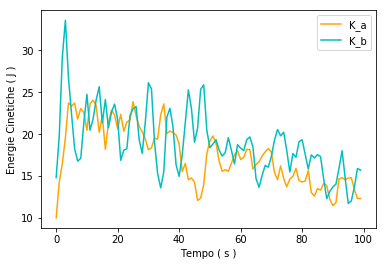

In [ ]:
plotFuncsE(0)

## Distribuzione delle Velocità ed Altezze
In questa parte, **decisamente molto più lenta**, introduciamo un $\tau_{therm} = 500s$ ed un tempo di misurazione $\tau_{meas} = 1000 s$. Le misurazioni vengono prelevate con $\Delta t = 0.1$ .
- Sfruttando l'array contentendo le velocità ( e coordinate ) di ogni particella, si calcola la quantità $v^2 = (\vec{v}\cdot\vec{v})$, con questa popolo un istogramma diviso per specie.
- Sempre utilizzando l'array citato prima, popolo un altro istogramma contente la distribuzione delle altezze delle particelle divise per specie.

Si può notare che gli istogrammi del quadrato delle velocità $v^2$ evidenziano una distribuzione esponenziale.
<br><br>
<b>In realtà, la simulazione che segue è stata rimodulata nelle tempistiche ($\tau = 150 s$, $\tau_{meas} = 140 s$, $\tau_{therm} = 10 s$) in quanto in una macchina moderna (*Intel Core i5 6a gen*) impiegherebbe altrimenti circa 20 minuti per concludersi.<br>Se si desidera si possono comunque inserire i tempi richiesti.</b>

In [ ]:
# INPUT 
t = 1500
t_term = 500
# invocazione funzione di preparazione
box, dt = prepare(30, 30, 0.025, 0.05, t_term)
# init componenti grafiche
fig, particles, particles2, rect, ax = figprx()
# animazione
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=t*10, interval=20, blit=True)
HTML(anim.to_html5_video())

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:115: RuntimeWarning: invalid value encountered in double_scalars
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in double_scalars
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in less
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in greater
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:127: RuntimeWarning: invalid value encountered in less
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in less
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in greater


In [ ]:
# calcolo distribuzione velocità particelle specie A (pitagora)
_vvDistA = np.array([])
for i in range(len(list(box.chunks(box.storeA,box.Na)))):
    for j in range(box.Na):
        itemx = list(box.chunks(box.storeA,box.Na))[i][j,2]
        itemy = list(box.chunks(box.storeA,box.Na))[i][j,3]
        value = (itemx ** 2) + (itemy ** 2)
        _vvDistA = np.append((_vvDistA),value)

# calcolo distribuzione velocità particelle specie B (np.dot())
_vvDistB = np.array([])
for i in range(len(list(box.chunks(box.storeB,box.Nb)))):
    for j in range(box.Nb):
        item = list(box.chunks(box.storeB,box.Nb))[i][j,2:]
        _vvDistB = np.append((_vvDistB),np.dot(item, item))

plt.hist(_vvDistA, bins = 'auto', color='orange')
plt.legend(['Distribuzione velocità specie A'], loc='upper right')
plt.show()

plt.hist(_vvDistB, bins = 'auto', color='c')
plt.legend(['Distribuzione velocità specie B'], loc='upper right')
plt.show()

Il picco sullo $0$ è dato dalla lettura dei valori nulli iniziali nel tempo $\tau_{therm}$.
<br><br><b>Riducendo al minuto quest'ultimo si noterà sempre meglio l'andamento esponenziale delle distribuzioni.</b>

In [ ]:
# calcolo distribuzione altezze (distanza da lato inferiore) particelle specie A
_hDistA = np.array([])
for i in range(len(list(box.chunks(box.storeA,box.Na)))):
    for j in range(box.Na):
        item = (list(box.chunks(box.storeA,box.Na))[i][j,1])
        _hDistA = np.append((_hDistA),item)
# calcolo distribuzione altezze (distanza da lato inferiore) particelle specie B
_hDistB = np.array([])
for i in range(len(list(box.chunks(box.storeB,box.Nb)))):
    for j in range(box.Nb):
        item = (list(box.chunks(box.storeB,box.Nb))[i][j,1])
        _hDistB = np.append((_hDistB),item)
    
plt.hist(_hDistA, bins = 'auto', color='orange')
plt.legend(['Distribuzione altezze specie A'], loc='upper right')
plt.show()

plt.hist(_hDistB, bins = 'auto', color='c')
plt.legend(['Distribuzione altezze specie B'], loc='upper right')
plt.show()